Esta notebook hace el pre-procesmiento de todos los .nii en una carpeta

# Configuración

In [3]:
inputFolder = "/Users/hugom/My Drive (hugomassaroli@gmail.com)/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped"
# inputFile = "/Users/hugom/PET-IA/Full-DBs/ADNI-Full-PostProc/ADNI-FULL-PostProc_11_29_2022_UniformResolution.csv"
inputFile = "/Users/hugom/PET-IA/Full-DBs/ADNI-Full-PostProc/ADNI-FULL-PostProc_3_01_2023_UniformResolution.csv"
outputFolder = "/Users/hugom/My Drive (hugomassaroli@gmail.com)/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed2"
minSliceSurface= 100.0*100.0
angle = 8

# Ejecución

In [4]:
import dicom2nifti
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import SimpleITK as sitk # para calcular rangos
import numpy as np
import io
from PIL import Image
import random
import pandas as pd
from pathlib import Path
from matplotlib import pyplot
import time
import gc

In [5]:
# https://stackoverflow.com/questions/8598673/how-to-save-a-pylab-figure-into-in-memory-file-which-can-be-read-into-pil-image
def fig2img(fig, dpi = 64):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, facecolor='black', edgecolor='none', dpi = dpi, transparent=False) # dpi Requerido para que la imagen sea 512x512
    buf.seek(0)
    img = Image.open(buf)
    return img

In [6]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndi.zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = ndi.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [2]:
# Devuelve un array de índices que deben ser borrados de la imágen Nifti por no cumplir una superfície mínima
def getIndexesToBeDeleted(sample, minSliceSurface = None, pixelSurface = 1.5, minSliceSurfaceThreshold = 0.0):
    # Chequeo de eliminar slices por superfície
    if minSliceSurface == None:
        return []
    
    brain_vol_data = sample.get_fdata()
    
    withMoreThan100 = 0
    deleteIndices = []
    if minSliceSurface <= 0.0:
        raise Exception("minSliceSurface should be > 0.0")
    
    for i in range(0, brain_vol_data.shape[2]):
        surface = 0.0
        sliceMatrix = brain_vol_data[:, :, i]
        sliceArray = sliceMatrix.reshape(-1)
        surface =  ( ( sliceArray > minSliceSurfaceThreshold ).sum() ) * pixelSurface
        if surface >= minSliceSurface:
            withMoreThan100 += 1
        else:
            deleteIndices.append(i)
        if withMoreThan100 < 16:
            raise Exception('No enough brain surface (' + str(withMoreThan100) + ' slices)')
            
    return deleteIndices

In [16]:
def transformGridImage(sample, outputImage = None, angle = None, zoom = None, shiftX = None, shiftY = None, 
                        angleTransformChance = 0.1, zoomTransformChance = 0.1, shiftTransformChance = 0.1, 
                        slicesToCut = 0, deleteIndices):
    brain_vol_data = sample.get_fdata()
    fig_rows = 4
    fig_cols = 4
    n_subplots = fig_rows * fig_cols
    
    brain_vol_data = np.delete(brain_vol_data, deleteIndices, axis=2)
            
    # We also replace all values < minSliceSurfaceThreshold with 0
    # In this way we "normalize" the images
    
    n_slice = brain_vol_data.shape[2]

    slices_to_eliminate = slicesToCut

    n_slice_padding = slices_to_eliminate // 2 # quitamos los primeros y ultimos n slices
    n_slice = n_slice - slices_to_eliminate

    step_size = n_slice / n_subplots

    slice_indices = np.arange(n_slice_padding, n_slice_padding + n_slice, step = step_size)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10], facecolor='black')
    
    if angle == None or angleTransformChance < random.uniform(0.0, 1.0):
        angle = 0.0 # Disable random angle
        
    if zoom != None and random.uniform(0.0, 1.0) > zoomTransformChance:
        zoom = None
        
    if shiftX != None and random.uniform(0.0, 1.0) > shiftTransformChance:
        shiftX = None
        
    if shiftY != None and random.uniform(0.0, 1.0) > shiftTransformChance:
        shiftY = None

    idx = 0
    for img in slice_indices:
        processedImage = ndi.rotate(brain_vol_data[:, :, round(img)], 90.0 + angle, mode='constant', reshape = False)
        if zoom != None:
            processedImage = clipped_zoom(processedImage, zoom)
        if shiftX != None:
            processedImage = ndi.shift(processedImage, [0.0, shiftX])
        if shiftY != None:
            processedImage = ndi.shift(processedImage, [shiftY, 0.0])
        axs.flat[idx].imshow(np.squeeze(processedImage), cmap='gray', vmin = minSliceSurfaceThreshold) # TODO: this can be wrong for other datasets
        axs.flat[idx].axis('off')
        idx += 1
        
    plt.tight_layout(pad=0.0)

    if outputImage:
            fig.savefig(outputImage, facecolor='black', dpi = 64, transparent=False) # dpi Requerido para que la imagen sea 512x512
            plt.close(fig) # Para que no muestre la imágen
            pyplot.clf()
            plt.cla()
            plt.clf()
            plt.close('all')
            return
    else:
            image = fig2img(fig)
            plt.close(fig) # Para que no muestre la imágen
            pyplot.clf()
            plt.cla()
            plt.clf()
            plt.close('all')
            return image

In [8]:
brain_vol = nib.load('/Users/hugom/My Drive (hugomassaroli@gmail.com)/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped/ADNI_016_S_4902_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20121003095425916_82_S168893_I337880.nii')
type(brain_vol)

nibabel.nifti1.Nifti1Image

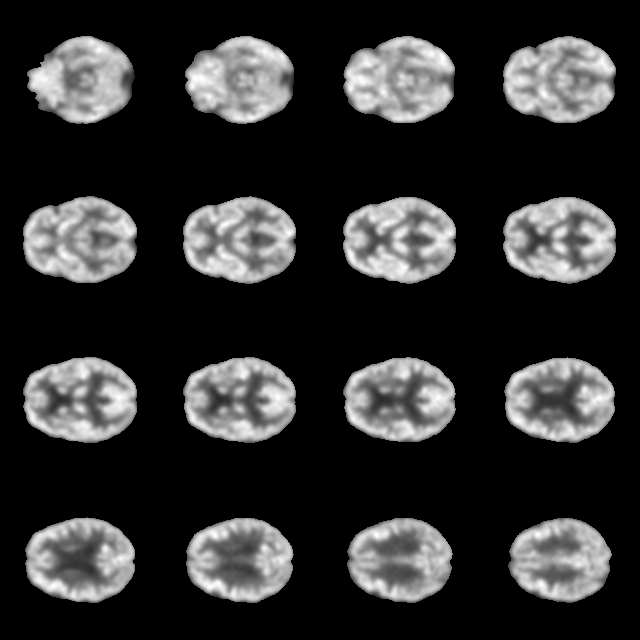

In [9]:
img = transformGridImage(brain_vol, angle = 90, angleTransformChance = 1.0, minSliceSurface = minSliceSurface)
img

In [10]:
def generateImages(sample, sampleId, transformGridParams = {}):
    angle15Left = -15.0
    angle15Right = 15.0
    angle08Left = -8.0
    angle08Right = 8.0
    zoomIn = 1.1
    zoomOut = 0.9
    shiftXRight = 10.0
    shiftXLeft = -10.0
    shiftYTop = -10.0
    shiftYBottom = 10.0
    
    # Chequeo de eliminar slices por superfície
    deleteIndices = getIndexesToBeDeleted(brain_vol, **transformGridParams)
        
    sampleFolder = os.path.join(outputFolder, sampleId)
    
    isExist = os.path.exists(sampleFolder)
    
    if not isExist:
        os.makedirs(sampleFolder)
    
    # normal
    normalFile = os.path.join(sampleFolder, "normal.png")
    if not Path(normalFile).is_file():
        transformGridImage(brain_vol, normalFile, deleteIndices = deleteIndices)

    #return
    # angle15Left
    angle15LeftFile = os.path.join(sampleFolder, "angle15Left.png")
    if not Path(angle15LeftFile).is_file():
        transformGridImage(brain_vol, angle15LeftFile, angle = angle15Left, angleTransformChance = 1.0, deleteIndices = deleteIndices)

    # angle15Right
    angle15RightFile = os.path.join(sampleFolder, "angle15Right.png")
    if not Path(angle15RightFile).is_file():
        transformGridImage(brain_vol, angle15RightFile, angle = angle15Right, angleTransformChance = 1.0, deleteIndices = deleteIndices)

    # angle8Left
    angle8LeftFile = os.path.join(sampleFolder, "angle8Left.png")
    if not Path(angle8LeftFile).is_file():
        transformGridImage(brain_vol, angle8LeftFile, angle = angle08Left, angleTransformChance = 1.0, deleteIndices = deleteIndices)

    # angle8Right
    angle8RightFile = os.path.join(sampleFolder, "angle8Right.png")
    if not Path(angle8RightFile).is_file():
        transformGridImage(brain_vol, angle8RightFile, angle = angle08Right, angleTransformChance = 1.0, deleteIndices = deleteIndices)
    
    # zoomIn
    zoomInFile = os.path.join(sampleFolder, "zoomIn.png")
    if not Path(zoomInFile).is_file():
        transformGridImage(brain_vol, zoomInFile, zoom = zoomIn, zoomTransformChance = 1.0, deleteIndices = deleteIndices)

    # zoomOut
    zoomOutFile = os.path.join(sampleFolder, "zoomOut.png")
    if not Path(zoomOutFile).is_file():
        transformGridImage(brain_vol, zoomOutFile, zoom = zoomOut, zoomTransformChance = 1.0, deleteIndices = deleteIndices)

    # shiftXLeft
    shiftXLeftFile = os.path.join(sampleFolder, "shiftXLeft.png")
    if not Path(shiftXLeftFile).is_file():
        transformGridImage(brain_vol, shiftXLeftFile, shiftX = shiftXLeft, shiftTransformChance = 1.0, deleteIndices = deleteIndices)
    
    # shiftXRight
    shiftXRightFile = os.path.join(sampleFolder, "shiftXRight.png")
    if not Path(shiftXRightFile).is_file():
        transformGridImage(brain_vol, shiftXRightFile, shiftX = shiftXRight, shiftTransformChance = 1.0, deleteIndices = deleteIndices)
    
    # shiftYTop
    shiftYTopFile = os.path.join(sampleFolder, "shiftYTop.png")
    if not Path(shiftYTopFile).is_file():
        transformGridImage(brain_vol, shiftYTopFile, shiftY = shiftYTop, shiftTransformChance = 1.0, deleteIndices = deleteIndices)
    
    # shiftYBottom
    shiftYBottomFile = os.path.join(sampleFolder, "shiftYBottom.png")
    if not Path(shiftYBottomFile).is_file():
        transformGridImage(brain_vol, shiftYBottomFile, shiftY = shiftYBottom, shiftTransformChance = 1.0, deleteIndices = deleteIndices)
    

In [11]:
# generateImages(brain_vol, "I337880")

In [12]:
csv = pd.read_csv(inputFile)

In [13]:
int(len(csv))

3762

In [14]:
# Esto es para generar las imágenes en batch ya que por algún motivo Python empieza a consumir toda la memoria
# Posiblemente nibabel o numpy tengan un memory leak
def generateRangeOfImages(start, end):
    print("Generating images from " + str(start) + " to " + str(end))
    for i in range(start, end):
        studyID = csv.iloc[i, 0]
        print("Progress: " + str(i) + "/" + str(len(csv)) + "stID: " + studyID)
        rglob = '*'+str(studyID)+'*.nii'
        for path in Path(inputFolder).rglob(rglob):
            filename = str(path)
            brain_vol = nib.load(filename)
            # Ejecutar todo de vuelta pero sin generar las imágenes? Chequear que todas tengan slices suficientes!!
            generateImages(brain_vol, studyID, transformGridParams = { "pixelSurface": 1.5 * 1.5 })
            brain_vol.uncache()
            del brain_vol
            if i != 0 and i % 20 == 0:
                gc.collect()
                # print("Sleeping a few seconds to clean memory")
                # time.sleep(5)

In [13]:
start = 600
stepSize = 100
end = min(len(csv), start + stepSize)
generateRangeOfImages(start, end)

Generating images from 600 to 700
Progress: 600/3762stID: I103901
Progress: 601/3762stID: I167914
Progress: 602/3762stID: I80864
Progress: 603/3762stID: I98718
Progress: 604/3762stID: I77708
Progress: 605/3762stID: I116276
Progress: 606/3762stID: I160807
Progress: 607/3762stID: I90117
Progress: 608/3762stID: I90121
Progress: 609/3762stID: I202055
Progress: 610/3762stID: I90113
Progress: 611/3762stID: I197343
Progress: 612/3762stID: I197197
Progress: 613/3762stID: I90109
Progress: 614/3762stID: I117599
Progress: 615/3762stID: I87127
Progress: 616/3762stID: I150689
Progress: 617/3762stID: I77236
Progress: 618/3762stID: I58988
Progress: 619/3762stID: I68317
Progress: 620/3762stID: I88371
Progress: 621/3762stID: I109006
Progress: 622/3762stID: I276613
Progress: 623/3762stID: I162849
Progress: 624/3762stID: I67633
Progress: 625/3762stID: I105273
Progress: 626/3762stID: I86505
Progress: 627/3762stID: I77232
Progress: 628/3762stID: I135499
Progress: 629/3762stID: I63666
Progress: 630/3762stID

# Fleni

In [17]:
inputFolder = "/Users/hugom/PET-IA/Full-DBs/fleni-base-myrian/imagenes-a-stripear-stripped"
outputFolder = "/Users/hugom/My Drive (hugomassaroli@gmail.com)/Tesis/Imagenes/fleni-stripped-preprocessed2"
rglob = '*.nii'
for path in Path(inputFolder).rglob(rglob):
    filename = str(path)
    filenamWOExtension = path.stem
    print("Processing " + filenamWOExtension)
    brain_vol = nib.load(filename)
   
    generateImages(brain_vol, filenamWOExtension, transformGridParams = { "pixelSurface": 2.0 * 2.0 })

Processing 09efaaf6-0cd6e473-a1c9c639-93a6c720-00fe0276
Processing b074b96f-18d5698c-9308ca22-8b7652aa-50445d55
Processing e785e1ae-4cc6f186-7984308a-d879a1f0-bcd90f94
Processing 4d837680-a00ddaa5-11e47c28-5756fd5a-8eb63ca0
Processing 83f4bb05-3997aa87-b05aa201-c4dc5c0f-77825f68
Processing 1541a4b6-f7f308c1-9e017a0a-d247bc16-e3117067
Processing 5e28bc57-30e1abd2-a0a7d856-4fc1af1e-5bee10d2
Processing a2e304d1-2514af76-ecc94dba-b02dc2f0-dab26cfe
Processing a248637a-74b50589-b5ec9433-91d05f99-2cb3100d
Processing 849fbca1-680e7283-1343314b-103301e5-20ff587a
Processing 406a25ad-76aea02a-ec230091-a3635f25-2352171a
Processing 6559a881-0fc99b85-c04b11f4-d7843d40-6d628caa
Processing ab1703b1-54a114b0-cbecf273-b0800da7-07650005
Processing b45c1777-0cda6fa1-a786ce73-596a699d-dd2c51e4
Processing a33eb1ba-4a5092e1-69d9b29a-2e3a10a2-91914a92
Processing f5fc9431-ed4ebc72-6203d97a-e788b88d-874bf87a
Processing b87479c8-641ec909-8b8effc1-9b58a18a-573f8414
Processing b172e084-61708876-5cb503da-b65f4f85-e

In [35]:
print("fin")

fin
